# inStrain output for presence detection and statistical analysis thereof. 

This notebook contains the following:

In [1]:
import sys

In [ ]:
!{sys.executable} -m pip install statsmodels

In [ ]:
!{sys.executable} -m pip install sklearn

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ranksums, norm, ttest_ind, levene, fisher_exact
import statsmodels.stats.multitest as smt
from matplotlib.patches import Patch
from IPython.display import Image
import re
from sklearn.metrics import matthews_corrcoef

### Understanding InStrain Output

Looking at profile for sample SRR9113707. 

In [3]:
SRR9113707genome_info = pd.read_csv('data56_related_files/inStrain_output/SRR9113707.IS_genome_info.tsv', sep = '\t')

In [4]:
SRR9113707genome_info.head(5)

,genome,coverage,breadth,nucl_diversity,length,true_scaffolds,detected_scaffolds,coverage_median,coverage_std,coverage_SEM,...,d_prime_mean,consensus_divergent_sites,population_divergent_sites,SNS_count,SNV_count,filtered_read_pair_count,reads_unfiltered_pairs,reads_mean_PID,divergent_site_count,reads_unfiltered_reads
0,GCA_000615245.1_ASM61524v1_genomic.fna,0.000360,0.000178,NaN,2934843.0,63.0,2.0,0,0.029992,0.000018,...,NaN,0.0,0.0,0.0,0.0,4,14,0.942499,0.0,83
1,GCA_001311745.1_ASM131174v1_genomic.fna,0.000714,0.000368,NaN,2501983.0,141.0,3.0,0,0.042393,0.000027,...,NaN,0.0,0.0,0.0,0.0,7,14,0.962989,0.0,106
2,GCA_001311765.1_ASM131176v1_genomic.fna,0.366775,0.023755,0.007367,2025929.0,114.0,35.0,0,4.153274,0.002935,...,0.990080,647.0,499.0,489.0,509.0,2727,4335,0.961450,998.0,10013
3,GCA_001435375.1_ASM143537v1_genomic.fna,0.791158,0.043833,0.003617,1475258.0,31.0,20.0,0,10.531403,0.008689,...,0.984408,695.0,635.0,633.0,182.0,4295,6389,0.952628,815.0,14600
4,GCA_002299975.1_ASM229997v1_genomic.fna,1.187498,0.120732,0.004095,1190495.0,150.0,95.0,0,5.376973,0.004991,...,0.992153,2232.0,2039.0,2033.0,659.0,5178,17858,0.926796,2692.0,45649


### Creating a dictionary with all genome_info dataframes as values to their sampleNames as keys

In [5]:
path = 'data56_related_files/inStrain_output/genome_info/'

In [6]:
sample_df_dict = {}
for filename in os.listdir(path):
    if filename.endswith(".tsv"): 
        file = (os.path.join(path, filename))
        sampleName = (filename[:10])
        df = pd.read_csv(file, sep = '\t')
        sample_df_dict[sampleName] = df    
        continue
    else:
        continue

In [7]:
sample_df_dict.keys()

dict_keys(['SRR6323514', 'SRR6323338', 'SRR9113725', 'SRR6323200', 'SRR6323295', 'SRR6323172', 'SRR6323243', 'ERR2241891', 'SRR9113706', 'ERR2241651', 'SRR6323250', 'SRR6323296', 'ERR2241849', 'SRR6323197', 'SRR6323205', 'SRR6323134', 'SRR6323343', 'SRR6323414', 'SRR6323167', 'ERR2241899', 'ERR2241647', 'ERR2241919', 'ERR2241649', 'ERR2241887', 'SRR6323449', 'SRR6323340', 'SRR6323502', 'SRR6323350', 'ERR2241927', 'ERR2241655', 'SRR6323244', 'SRR6323249', 'SRR6323550', 'SRR6323503', 'ERR2241945', 'SRR6323493', 'ERR2241860', 'SRR6323384', 'ERR2241925', 'SRR6323088', 'SRR6323530', 'SRR9113691', 'SRR6323247', 'ERR2241848', 'ERR2241893', 'ERR2241855', 'SRR9113707', 'SRR6323516', 'SRR9113737', 'ERR2241923', 'ERR2241856', 'ERR2241890', 'ERR2241653', 'SRR6323556', 'SRR6323252', 'SRR6323367'])

In [9]:
sample_df_dict['SRR9113737'].head(5)

,genome,coverage,breadth,nucl_diversity,length,true_scaffolds,detected_scaffolds,coverage_median,coverage_std,coverage_SEM,...,d_prime_mean,consensus_divergent_sites,population_divergent_sites,SNS_count,SNV_count,filtered_read_pair_count,reads_unfiltered_pairs,reads_mean_PID,reads_unfiltered_reads,divergent_site_count
0,GCA_001311425.1_ASM131142v1_genomic.fna,0.000376,0.000111,NaN,3009421.0,108.0,1.0,0,0.037469,0.000022,...,NaN,0.0,0.0,0.0,0.0,4,6,0.946118,21,0.0
1,GCA_001311745.1_ASM131174v1_genomic.fna,0.002189,0.000404,0.004121,2501983.0,141.0,3.0,0,0.155992,0.000099,...,NaN,0.0,0.0,0.0,1.0,20,24,0.955050,70,1.0
2,GCA_001311765.1_ASM131176v1_genomic.fna,0.864116,0.016931,0.005568,2025929.0,114.0,27.0,0,12.025872,0.008497,...,0.988013,576.0,490.0,477.0,373.0,6406,10694,0.959319,24582,850.0
3,GCA_001435375.1_ASM143537v1_genomic.fna,0.104168,0.015359,0.004900,1475258.0,31.0,19.0,0,1.580280,0.001304,...,1.000000,157.0,137.0,136.0,74.0,561,911,0.947433,2074,210.0
4,GCA_002299975.1_ASM229997v1_genomic.fna,0.850298,0.099734,0.003239,1190495.0,150.0,90.0,0,3.870157,0.003593,...,0.995983,1660.0,1565.0,1575.0,397.0,3698,13709,0.926474,35786,1972.0


### Keeping rows in df that have breadth ≥ 0.5 (Aka present genomes) 

In [10]:
for key in sample_df_dict:
    sample_df_dict[key] = sample_df_dict[key][sample_df_dict[key]['breadth'] >= 0.5]

In [11]:
sample_df_dict['SRR9113737'].head(5)

,genome,coverage,breadth,nucl_diversity,length,true_scaffolds,detected_scaffolds,coverage_median,coverage_std,coverage_SEM,...,d_prime_mean,consensus_divergent_sites,population_divergent_sites,SNS_count,SNV_count,filtered_read_pair_count,reads_unfiltered_pairs,reads_mean_PID,reads_unfiltered_reads,divergent_site_count
18,GCF_000159355.1_ASM15935v1_genomic.fna,10.894628,0.638092,0.002780,1780499.0,32.0,9.0,5,16.991962,0.012757,...,0.994923,6779.0,5702.0,5689.0,4672.0,71549,74156,0.973689,150941,10361.0
19,GCF_000159435.1_ASM15943v1_genomic.fna,5.272091,0.685744,0.003147,1877332.0,112.0,41.0,3,6.467687,0.004749,...,0.990399,3078.0,2054.0,2067.0,4200.0,36307,37654,0.970003,78691,6267.0
47,GCF_000614735.1_ASM61473v1_genomic.fna,112.460415,0.943509,0.007117,1918774.0,74.0,69.0,99,98.522592,0.071401,...,0.950691,6651.0,2471.0,2429.0,33151.0,793464,809298,0.987219,1651572,35580.0
48,GCF_000615285.1_ASM61528v1_genomic.fna,34.444695,0.748058,0.007080,1902496.0,35.0,32.0,24,42.902854,0.031162,...,0.979687,19498.0,13725.0,13527.0,24800.0,240561,264813,0.975195,551195,38327.0
151,GCF_002088015.1_ASM208801v1_genomic.fna,8.459936,0.709072,0.004966,2069542.0,129.0,114.0,4,22.359650,0.015641,...,0.940477,4828.0,2583.0,2566.0,9343.0,64613,71059,0.987016,153437,11909.0


### Reducing the df to a list of present genomes

In [12]:
for key in sample_df_dict:
    sample_df_dict[key] = sample_df_dict[key]['genome']

In [13]:
sample_df_dict['SRR9113737'].head(5)

18      GCF_000159355.1_ASM15935v1_genomic.fna
19      GCF_000159435.1_ASM15943v1_genomic.fna
47      GCF_000614735.1_ASM61473v1_genomic.fna
48      GCF_000615285.1_ASM61528v1_genomic.fna
151    GCF_002088015.1_ASM208801v1_genomic.fna
Name: genome, dtype: object

In [14]:
len(sample_df_dict.keys())

56

### Creating a binary presence/abesence matrix with sample name as row and present species as columns

In [15]:
df = pd.concat([
          pd.Series(v, name=k).astype(str) for k, v in sample_df_dict.items()
     ], 
     axis=1)
binary_sample_vs_genomes = pd.get_dummies(df.stack()).sum(level=1)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  """


In [16]:
binary_sample_vs_genomes.columns.str.rsplit('_',2)[0][0]

'GCA_900557215.1'

In [17]:
binary_sample_vs_genomes = binary_sample_vs_genomes.rename(columns = lambda x: re.sub('(?<=.1_).*$', '', x))

In [19]:
binary_sample_vs_genomes.head(5)

,GCA_900557215.1_,GCF_000016825.1_,GCF_000159355.1_,GCF_000159435.1_,GCF_000160575.1_,GCF_000193635.1_,GCF_000423265.1_,GCF_000614735.1_,GCF_000615285.1_,GCF_001433855.1_,...,S2C3320.fna,S33C4056.fna,S36C1134.fna,S42C891.fna,S49C1120.fna,S4C569.fna,S52C595.fna,S5C1113.fna,S8C2455.fna,S9C3913.fna
SRR9113707,1,0,0,1,0,0,0,1,1,0,...,0,0,0,0,0,1,1,0,0,0
ERR2241649,1,1,1,1,0,0,1,1,0,0,...,1,0,0,0,0,1,0,1,0,0
ERR2241899,1,0,1,1,0,0,1,1,1,0,...,1,0,1,0,0,1,0,1,0,0
ERR2241647,1,1,0,1,0,0,0,1,0,0,...,1,0,0,0,0,1,0,0,0,0
ERR2241849,1,0,1,1,0,0,0,1,0,0,...,1,0,1,0,0,1,0,1,0,0


In [23]:
# count of presence for each genome
sorted(binary_sample_vs_genomes.sum())

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 4,
 4,
 5,
 5,
 5,
 6,
 7,
 7,
 7,
 7,
 7,
 8,
 8,
 8,
 8,
 10,
 11,
 13,
 14,
 14,
 14,
 14,
 20,
 20,
 23,
 23,
 27,
 27,
 27,
 28,
 28,
 29,
 29,
 31,
 32,
 32,
 33,
 38]

In [24]:
binary_sample_vs_genomes.sum().describe()

count    57.000000
mean     11.701754
std      11.117819
min       1.000000
25%       2.000000
50%       7.000000
75%      20.000000
max      38.000000
dtype: float64

In [25]:
# count of number of genomes in each sample
sorted(binary_sample_vs_genomes.sum(axis=1))

[1,
 1,
 1,
 3,
 4,
 4,
 5,
 5,
 6,
 7,
 7,
 8,
 8,
 8,
 9,
 11,
 12,
 13,
 13,
 14,
 14,
 14,
 15,
 15,
 15,
 15,
 16,
 16,
 16,
 16,
 16,
 16,
 17,
 18,
 18,
 19,
 19,
 19,
 19,
 20,
 20,
 21,
 22,
 22,
 23,
 24,
 27,
 35]

In [26]:
binary_sample_vs_genomes.sum(axis=1).describe()

count    48.000000
mean     13.895833
std       7.305607
min       1.000000
25%       8.000000
50%      15.000000
75%      19.000000
max      35.000000
dtype: float64

#### saving the observed genomes for later use

In [20]:
reference_genomes = list(binary_sample_vs_genomes.columns)

In [122]:
pd.DataFrame(reference_genomes)[:-1].to_csv('data56_related_files/present_ref_genomes.tsv', index=False, header = False)

### Checking that all bins are present as reference genome

In [28]:
count = 0
for name in reference_genomes:
    if name.startswith("S"):
#         print(name)
        count += 1
print(count)
# The original number of bins used as a reference was 28 after dRep with all the db ref. genomes. 
# The bins are created from the samples so if they are not present something went wrong.

28


### Which samples do not have any Lactobacillaceae ?

In [30]:
positive_samples = list(binary_sample_vs_genomes.index)

all_samples = list(sample_df_dict.keys())

In [31]:
len(positive_samples)

48

In [32]:
len(all_samples)

56

In [33]:
negative_samples = set(positive_samples).symmetric_difference(set(all_samples))

In [34]:
negative_samples

{'SRR6323088',
 'SRR6323134',
 'SRR6323200',
 'SRR6323249',
 'SRR6323250',
 'SRR6323340',
 'SRR6323343',
 'SRR6323449'}

8 samples not containing any Lactobacillaceae reads (with breadth above 50%). All of them are samples from farms in China - see below when combined with metadata

### Including Metadata

In [35]:
metadata = pd.read_csv('data56_related_files/Metadata_56samples.tsv', sep = '\t')

In [36]:
metadata.head(4)

,Dataset,ID,Country,gender,age.days.,Breed,isolation.location,type,Feed,Temperature,...,vaccine,vægt,humidity,sequencing.method,DNA.extraction,Sample.replicate,location_name.farm.,farm_ID,G_bases,avg Mbases
0,Huang,SRR6323134,China,male,42,Arbor Acres broiler,cecum,broiler,None,reduced from 35 °C on day 1 to 24 °C on day 21...,...,Combined Newcastle disease virus (NDV) and inf...,NaN,NaN,HiSeq X Ten,NaN,pooled digesta from five chickens,China:Beijing,china1,2.4,NaN
1,Huang,SRR6323252,China,male,42,Arbor Acres broiler,duodenum,broiler,None,reduced from 35 °C on day 1 to 24 °C on day 21...,...,Combined Newcastle disease virus (NDV) and inf...,NaN,NaN,HiSeq X Ten,NaN,pooled digesta from five chickens,China:Beijing,china1,2.8,NaN
2,Huang,SRR6323384,China,male,42,Arbor Acres broiler,ileum,broiler,None,reduced from 35 °C on day 1 to 24 °C on day 21...,...,Combined Newcastle disease virus (NDV) and inf...,NaN,NaN,HiSeq X Ten,NaN,pooled digesta from five chickens,China:Beijing,china1,2.6,NaN
3,Huang,SRR6323414,China,male,42,Arbor Acres broiler,jejunum,broiler,None,reduced from 35 °C on day 1 to 24 °C on day 21...,...,Combined Newcastle disease virus (NDV) and inf...,NaN,NaN,HiSeq X Ten,NaN,pooled digesta from five chickens,China:Beijing,china1,3.0,NaN


In [37]:
metadata['location_name.farm.'] = metadata['location_name.farm.'].str.replace('UK:South-east England', 'UK')

#### Metadata on the samples with no Lactobacillacea reads

In [39]:
metadata[metadata['ID'].isin(negative_samples)]

,Dataset,ID,Country,gender,age.days.,Breed,isolation.location,type,Feed,Temperature,...,vaccine,vægt,humidity,sequencing.method,DNA.extraction,Sample.replicate,location_name.farm.,farm_ID,G_bases,avg Mbases
0,Huang,SRR6323134,China,male,42,Arbor Acres broiler,cecum,broiler,None,reduced from 35 °C on day 1 to 24 °C on day 21...,...,Combined Newcastle disease virus (NDV) and inf...,NaN,NaN,HiSeq X Ten,NaN,pooled digesta from five chickens,China:Beijing,china1,2.4,NaN
10,Huang,SRR6323250,China,male,42,Arbor Acres broiler,cecum,broiler,None,reduced from 35 °C on day 1 to 24 °C on day 21...,...,Combined Newcastle disease virus (NDV) and inf...,NaN,NaN,HiSeq X Ten,NaN,digesta from one chicken (biological replicate 2),China:Beijing,china3,3.5,NaN
11,Huang,SRR6323249,China,male,42,Arbor Acres broiler,cecum,broiler,None,reduced from 35 °C on day 1 to 24 °C on day 21...,...,Combined Newcastle disease virus (NDV) and inf...,NaN,NaN,HiSeq X Ten,NaN,digesta from one chicken (biological replicate 1),China:Beijing,china3,3.1,NaN
13,Huang,SRR6323200,China,female,56,Local yellow-feather chickens,cecum,layer,None,reduced from 35 °C on day 1 to 24 °C on day 21...,...,Combined Newcastle disease virus (NDV) and inf...,NaN,NaN,Illumina HiSeq 2500,NaN,digesta from one chicken (biological replicate 3),China:Hunan,china4,5.0,NaN
17,Huang,SRR6323343,China,female,62,Yellow dwarf chicken,colorectum,broiler,not collected,reduced from 35 °C on day 1 to 24 °C on day 21...,...,Combined Newcastle disease virus (NDV) and inf...,NaN,NaN,HiSeq X Ten,NaN,digesta from one chicken (biological replicate 2),China:Guandong,china5,5.5,NaN
18,Huang,SRR6323088,China,female,62,Yellow dwarf chicken,cecum,broiler,not collected,reduced from 35 °C on day 1 to 24 °C on day 21...,...,Combined Newcastle disease virus (NDV) and inf...,NaN,NaN,Illumina HiSeq 2500,NaN,digesta from one chicken (biological replicate 1),China:Guandong,china5,4.6,NaN
20,Huang,SRR6323340,China,male,62,Yellow dwarf chicken,cecum,broiler,not collected,reduced from 35 °C on day 1 to 24 °C on day 21...,...,Combined Newcastle disease virus (NDV) and inf...,NaN,NaN,HiSeq X Ten,NaN,digesta from one chicken (biological replicate 2),China:Guandong,china5,6.9,NaN
21,Huang,SRR6323449,China,female,78,Guangxi local chicken,cecum,broiler,not collected,reduced from 35 °C on day 1 to 24 °C on day 21...,...,Combined Newcastle disease virus (NDV) and inf...,NaN,NaN,Illumina HiSeq 2500,NaN,digesta from one chicken (biological replicate 3),China:Hunan,china6,4.1,NaN


#### Combining metadata with binary sample vs genome matrix 

In [40]:
binary_sample_vs_genomes['ID'] = binary_sample_vs_genomes.index

In [41]:
meta_binary_genome_info = pd.merge(metadata, binary_sample_vs_genomes, how="inner", on='ID')

In [42]:
meta_binary_genome_info.head(5)

,Dataset,ID,Country,gender,age.days.,Breed,isolation.location,type,Feed,Temperature,...,S2C3320.fna,S33C4056.fna,S36C1134.fna,S42C891.fna,S49C1120.fna,S4C569.fna,S52C595.fna,S5C1113.fna,S8C2455.fna,S9C3913.fna
0,Huang,SRR6323252,China,male,42,Arbor Acres broiler,duodenum,broiler,None,reduced from 35 °C on day 1 to 24 °C on day 21...,...,1,1,0,1,0,0,0,0,0,0
1,Huang,SRR6323384,China,male,42,Arbor Acres broiler,ileum,broiler,None,reduced from 35 °C on day 1 to 24 °C on day 21...,...,0,1,0,1,0,0,0,0,0,0
2,Huang,SRR6323414,China,male,42,Arbor Acres broiler,jejunum,broiler,None,reduced from 35 °C on day 1 to 24 °C on day 21...,...,1,1,0,1,0,0,0,1,0,0
3,Huang,SRR6323550,China,male,42,Arbor Acres broiler,colorectum,broiler,None,reduced from 35 °C on day 1 to 24 °C on day 21...,...,0,0,0,0,0,0,0,0,0,0
4,Huang,SRR6323556,China,female,42,Local yellow-feather chickens,cecum,layer,None,reduced from 35 °C on day 1 to 24 °C on day 21...,...,0,0,1,0,0,0,0,0,0,0


<AxesSubplot:xlabel='farm_ID'>

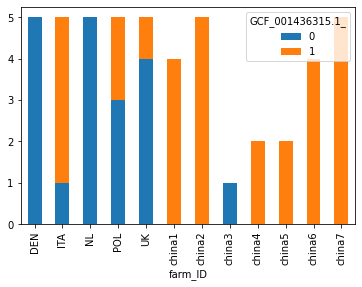

In [43]:
pd.crosstab(meta_binary_genome_info['farm_ID'],
            meta_binary_genome_info['GCF_001436315.1_']).plot.bar(stacked=True)


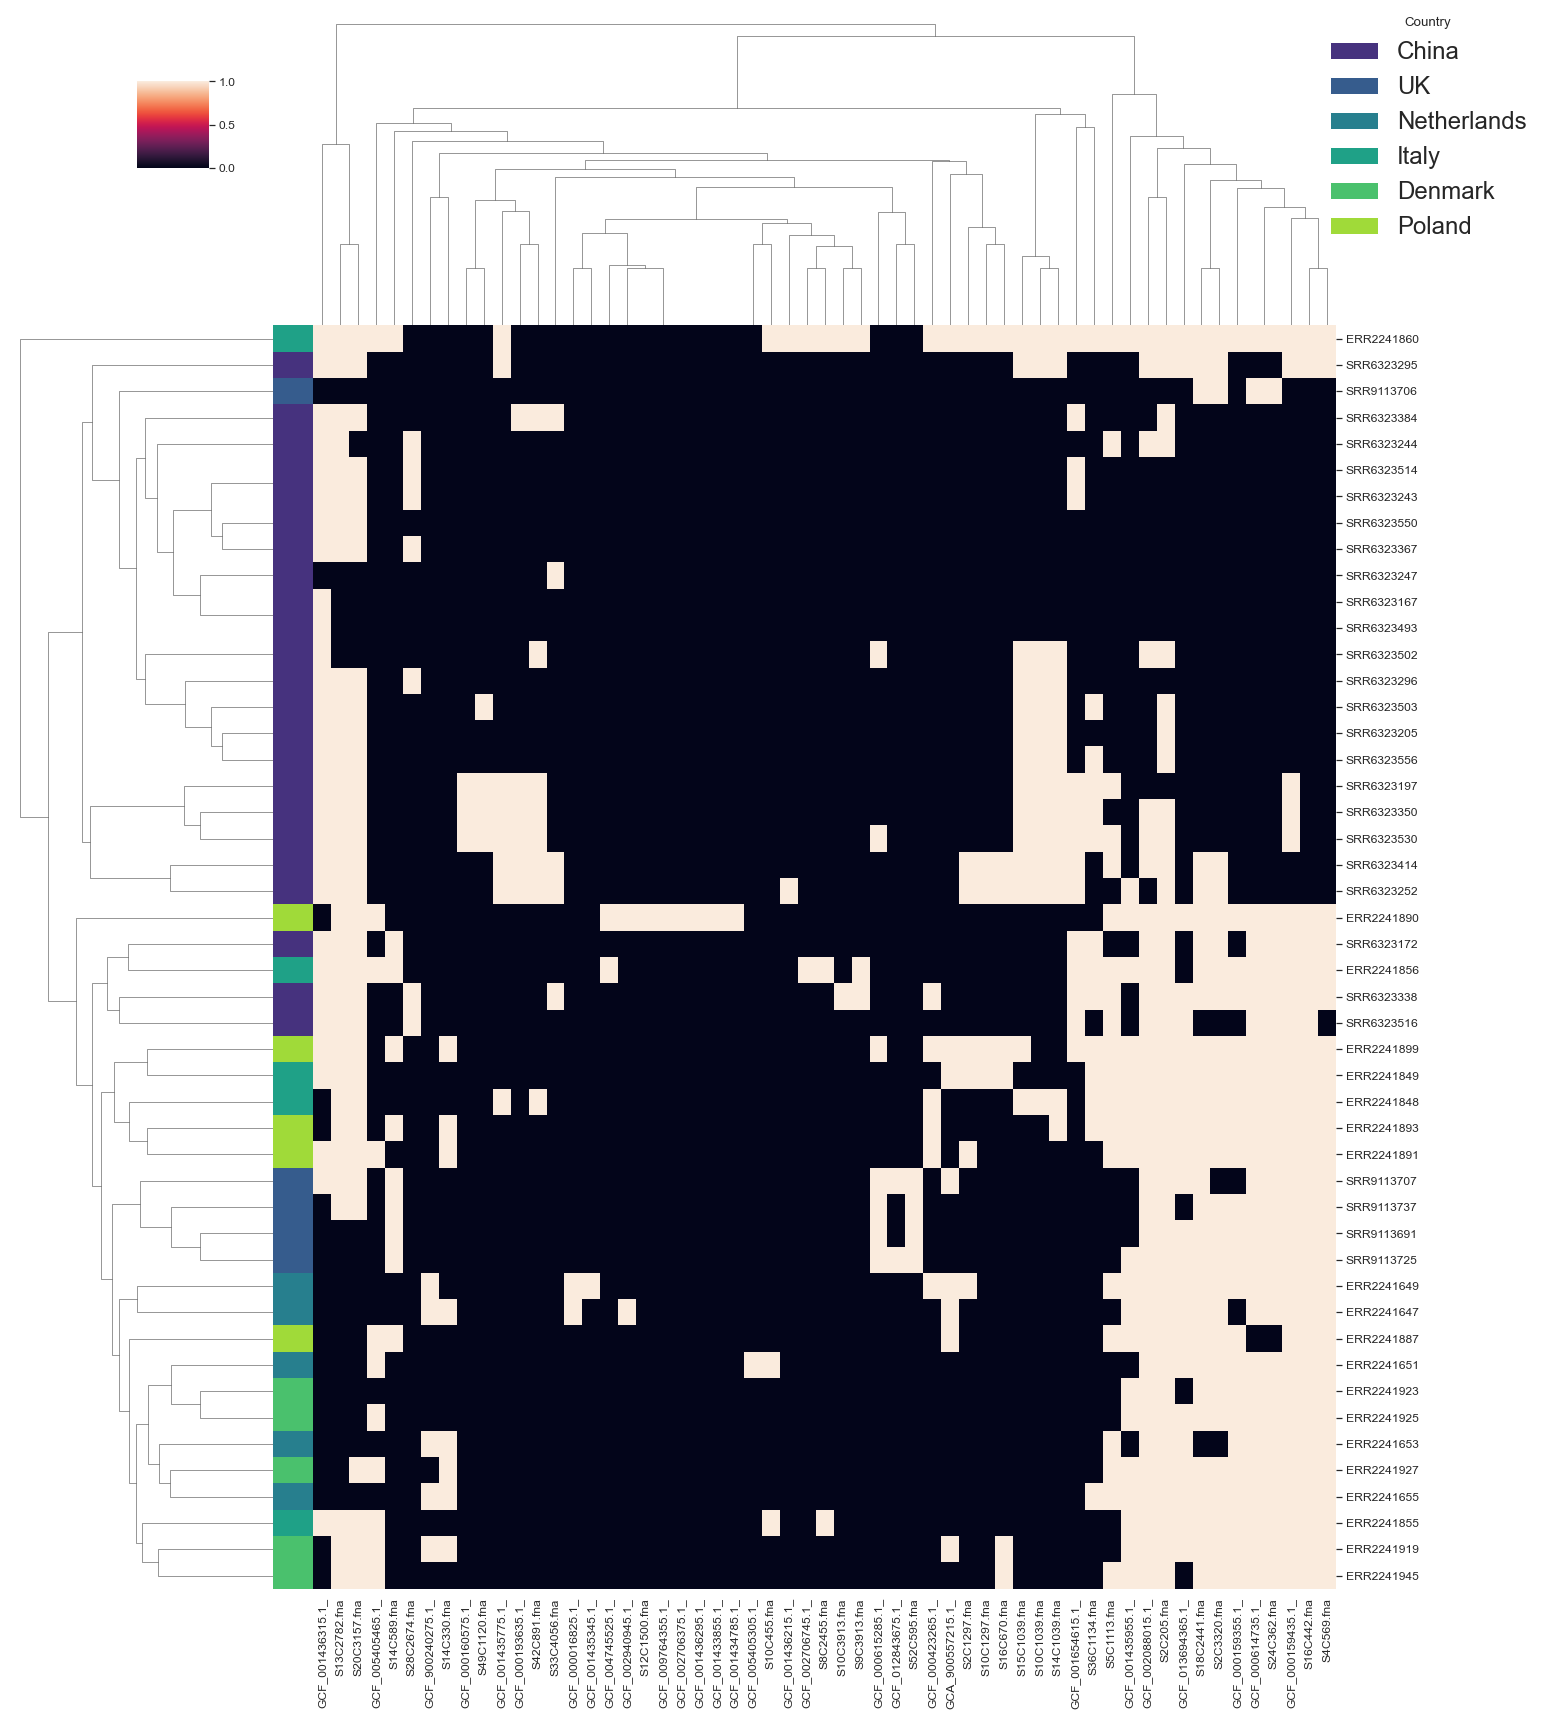

In [135]:
# lut1 = dict(zip(meta_binary_genome_info['Country'].unique(), ['#FFFF99','#330000','#555555','#330066','#CC6600','#009900']))
lut1 = dict(zip(meta_binary_genome_info['Country'].unique(), 
                sns.color_palette("viridis", 6)))


row_colors1 = meta_binary_genome_info['Country'].map(lut1)

row_colors1 = row_colors1.reindex(index = [23,28,43,29,33,44,34,38,24,
                                           1,2,25,3,30,26,4,5,31,39,40,32,6,
                                           41,42,35,45,46,36,37,47,7,27,8,9,
                                           10,11,12,13,14,15,16,17,18,19,20,21,
                                           22,0])

sns.set(font_scale = 1.1)
cmap = sns.clustermap( data = binary_sample_vs_genomes.drop('ID', axis=1), 
                    row_colors=[row_colors1], figsize=(20,24),
                    cbar_pos=(0.1, 0.9, 0.05, 0.05) )



handles = [Patch(facecolor=lut1[name]) for name in lut1]
plt.legend(handles, lut1, title='Country',
            bbox_to_anchor=(1.08, 1), bbox_transform=plt.gcf().transFigure,
           loc='upper right', fontsize=24, frameon=False )

plt.savefig('resultFigs/presence_apsencePlot.png',  bbox_inches='tight')



# colorbar = ax.collections[0].colorbar
# colorbar.set_ticks([0.25,0.75])
# colorbar.set_ticklabels(['0', '1'])


In [45]:
#sample with the most genomes present 
meta_binary_genome_info[meta_binary_genome_info['ID'] == 'ERR2241860']

,Dataset,ID,Country,gender,age.days.,Breed,isolation.location,type,Feed,Temperature,...,S2C3320.fna,S33C4056.fna,S36C1134.fna,S42C891.fna,S49C1120.fna,S4C569.fna,S52C595.fna,S5C1113.fna,S8C2455.fna,S9C3913.fna
37,Patrik Munk,ERR2241860,Italy,NaN,33.8 (average),NaN,Faecal,broiler,NaN,NaN,...,1,0,1,0,0,1,0,1,1,1


In [44]:
meta_binary_genome_info.to_csv('data56_related_files/meta_binary_genome_info_instrain.csv', index = False, header = True)

In [ ]:
meta_binary_genome_info.to_csv('data56_related_files/presence_with_metadata.csv', header = True, index = False)

### Statistical difference between China and Europe

In [46]:
# adding region column 
def conditions(s):
#     if (s['farm_ID'].isin(['china1', 'china2', 'china3', 'china4', 'china5', 'china6', 'china7'])):
    if 'china' in s['farm_ID']:
        return 'china'
    else:
        return 'europe'

In [47]:
meta_binary_genome_info['region'] = meta_binary_genome_info.apply(conditions, axis=1)

In [48]:
meta_binary_genome_info.groupby('region').count()

,Dataset,ID,Country,gender,age.days.,Breed,isolation.location,type,Feed,Temperature,...,S2C3320.fna,S33C4056.fna,S36C1134.fna,S42C891.fna,S49C1120.fna,S4C569.fna,S52C595.fna,S5C1113.fna,S8C2455.fna,S9C3913.fna
region,,,,,,,,,,,,,,,,,,,,,
china,23,23,23,23,23,23,23,23,23,23,...,23,23,23,23,23,23,23,23,23,23
europe,25,25,25,5,25,5,25,25,5,0,...,25,25,25,25,25,25,25,25,25,25


#### count difference in present genomes in China vs Europe

In [49]:
china_count = 0
europe_count = 0

meta_filtered = meta_binary_genome_info.drop(columns=['G_bases', 'avg Mbases'])

for key in meta_filtered.groupby('region').sum().keys():
    china_count += meta_filtered.groupby('region').sum()[key][0]
    europe_count += meta_filtered.groupby('region').sum()[key][1]

print('Number of times all genomes are present in China: ',china_count)
print('Number of tines all genomes are present in Europe: ',europe_count)

Number of times all genomes are present in China:  225.0
Number of tines all genomes are present in Europe:  442.0


### Finding genomes that have different distributions in China vs Europe
The funcition 

In [50]:
def statistically_significant(ranks_stats, alpha):
    statistically_different = {}

    for key in ranks_stats:
        if ranks_stats[key][1] <= alpha:
            statistically_different[key] = ranks_stats[key]
    
    return statistically_different

In [51]:
def add_adjusted_pvalue(stats_dict, alpha):
    
    p_val = []
    for key in stats_dict:
        p_val.append(stats_dict[key][1])
    
    adjusted_p = smt.multipletests(p_val, alpha=alpha, method='fdr_bh')[1]
    
    for index, key in enumerate(stats_dict):
        stats_dict[key] = [stats_dict[key], adjusted_p[index]]

    return stats_dict

In [52]:
def create_contingency_table(df1, df2, genome):

    presence_df1 = df1[df1[genome]==1].count()[genome]
    presence_df2 = df2[df2[genome]==1].count()[genome]
    
    contingency_table = [[presence_df1, len(df1)-presence_df1], 
                                                           [presence_df2, len(df2)-presence_df2]]
    return contingency_table

In [53]:
def calculate_stats_multiple_genomes(ref_genome, df1, df2):

    results = {}

    for genome in ref_genome:
        results[genome] = fisher_exact(create_contingency_table(df1, df2, genome))
            
#             results[genome]= [np.log(results[genome][0]),results[genome]]
          
    return results

In [54]:
def stat_diff(df, column, type1, type2, alpha, ref_genome = reference_genomes):
    '''Will return the genomes with statistically significant difference in distibution in Europe and China.
    It returns a dictionary with genome as key and the values are [(odds ratio, p-value), adjusted p-value] '''
    group1 = df[df[column] == type1]
    group2 = df[df[column] == type2]
    
    test_stats = calculate_stats_multiple_genomes(ref_genome, group1, group2)
    stats_adjusted_P = add_adjusted_pvalue(test_stats, alpha)
    
    return statistically_significant(stats_adjusted_P, alpha)

In [57]:
def all_stats(df, column, type1, type2, alpha, ref_genome = reference_genomes):
    '''Will return the statistics for all the genomes in a dictionary with genome as key 
    and the values are [(odds ratio, p-value), adjusted p-value] '''
    
    group1 = df[df[column] == type1]
    group2 = df[df[column] == type2]
    
    test_stats = calculate_stats_multiple_genomes(ref_genome, group1, group2)
    
    return add_adjusted_pvalue(test_stats, alpha)
    

In [58]:

stats_region_genomes = all_stats(meta_binary_genome_info, 'region', 'europe', 'china', alpha=0.01)

In [61]:
statistical_region_genomes_fisher = stat_diff(meta_binary_genome_info, 'region', 'europe', 'china',alpha=0.01)

In [62]:
statistical_region_genomes_fisher

{'GCF_000159355.1_': [(161.33333333333334, 1.7370799770782166e-09),
  3.651419572354424e-08],
 'GCF_000159435.1_': [(54.857142857142854, 1.722601543385758e-06),
  9.818828797298821e-06],
 'GCF_000614735.1_': [(160.0, 2.562399699897841e-09), 3.651419572354424e-08],
 'GCF_001435955.1_': [(69.66666666666667, 2.598983813607313e-07),
  2.1163153910802407e-06],
 'GCF_001436315.1_': [(0.017676767676767676, 1.0469103481848102e-06),
  6.630432205170465e-06],
 'GCF_002088015.1_': [(37.333333333333336, 2.2125406805775083e-05),
  0.00010509568232743165],
 'GCF_005405465.1_': [(inf, 0.0002571111521643141), 0.0011273335133358388],
 'GCF_013694365.1_': [(26.666666666666668, 3.2785593736610336e-06),
  1.6988898572607175e-05],
 'S16C442.fna': [(114.0, 1.6508203376333085e-08), 1.8819351849019718e-07],
 'S18C2441.fna': [(86.4, 8.899614768907736e-08), 8.45463403046235e-07],
 'S24C362.fna': [(160.0, 2.562399699897841e-09), 3.651419572354424e-08],
 'S2C3320.fna': [(41.4, 8.630827354959808e-07), 6.1494644904

In [63]:
#calculating log ratio:

for genome in statistical_region_genomes_fisher.keys():
    logOR = np.log(statistical_region_genomes_fisher[genome][0][0])
    print(genome, logOR)


GCF_000159355.1_ 5.083472618048522
GCF_000159435.1_ 4.004732403532413
GCF_000614735.1_ 5.075173815233827
GCF_001435955.1_ 4.243721963296702
GCF_001436315.1_ -4.035504062199167
GCF_002088015.1_ 3.619886582626985
GCF_005405465.1_ inf
GCF_013694365.1_ 3.283414346005772
S16C442.fna 4.736198448394496
S18C2441.fna 4.45898767581001
S24C362.fna 5.075173815233827
S2C3320.fna 3.7232808808312687
S4C569.fna 5.075173815233827


In [64]:
mostly_present_china = {}
mostly_present_europe = {}

for key in statistical_region_genomes_fisher:
    if statistical_region_genomes_fisher[key][0][0] < 1:
        mostly_present_china[key] = statistical_region_genomes_fisher[key]

    if statistical_region_genomes_fisher[key][0][0] > 1:
        mostly_present_europe[key] = statistical_region_genomes_fisher[key]

print('These Lactobacillaceae are more present in China')
print(mostly_present_china.keys())
print('These Lactobacillaceae are more present in Europe')
print(mostly_present_europe.keys())

These Lactobacillaceae are more present in China
dict_keys(['GCF_001436315.1_'])
These Lactobacillaceae are more present in Europe
dict_keys(['GCF_000159355.1_', 'GCF_000159435.1_', 'GCF_000614735.1_', 'GCF_001435955.1_', 'GCF_002088015.1_', 'GCF_005405465.1_', 'GCF_013694365.1_', 'S16C442.fna', 'S18C2441.fna', 'S24C362.fna', 'S2C3320.fna', 'S4C569.fna'])


Found 13 species with statitical significance of being distibuted differently in Europe and China. 1 of them were found significantly more in China while 12 was mainly found in Europe. 

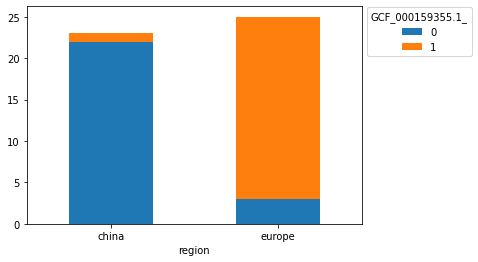

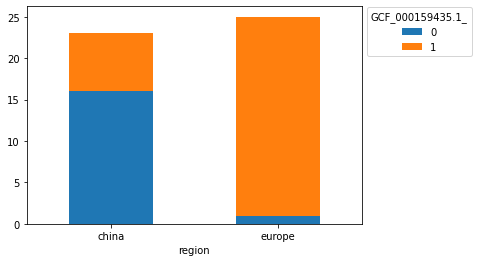

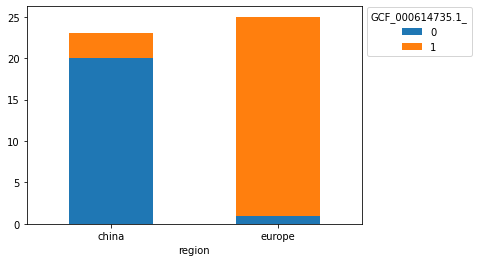

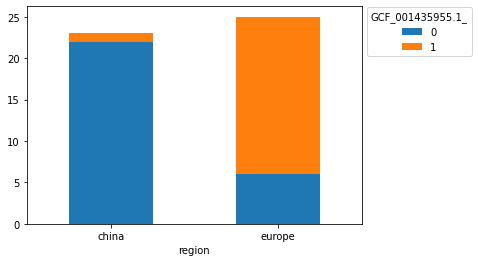

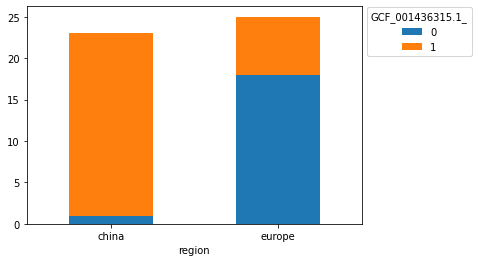

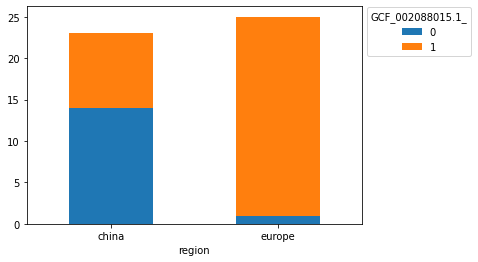

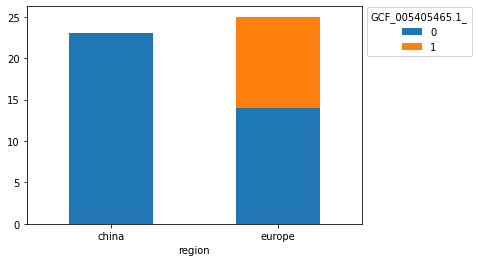

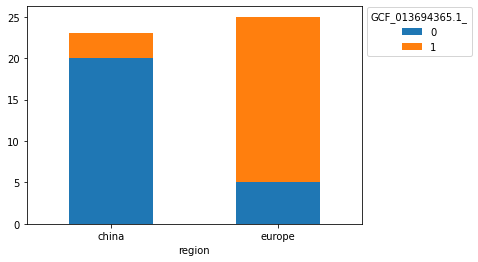

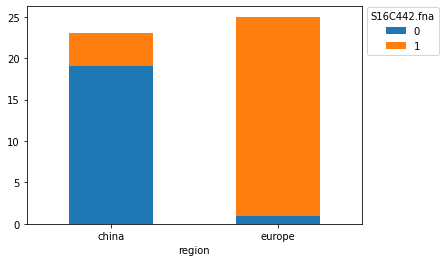

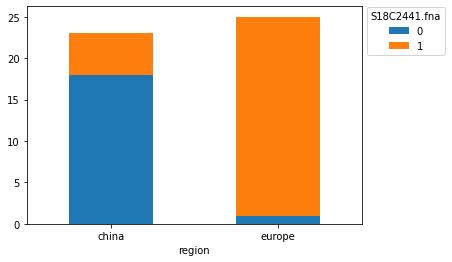

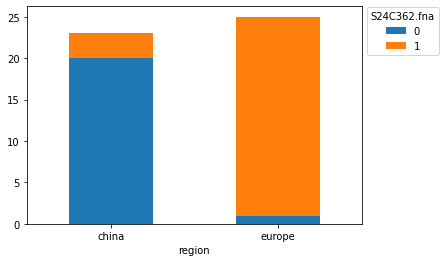

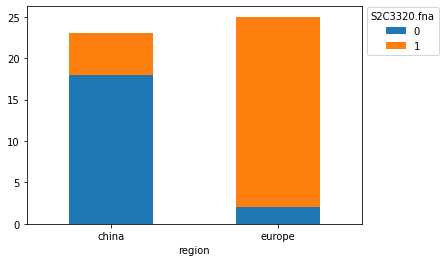

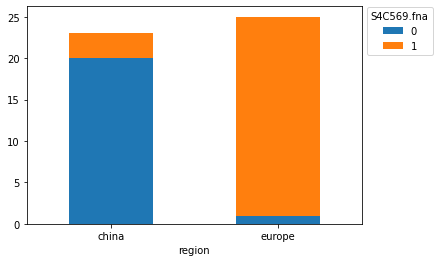

In [71]:
# fig, axes = plt.subplots(5,5, figsize=(12,6))

for idx, genome in enumerate(statistical_region_genomes_fisher.keys()): 
#     i= int((idx/5))
    
    ct = pd.crosstab(meta_binary_genome_info['region'],
            meta_binary_genome_info[genome])
    fig = ct.plot(kind='bar', stacked=True, rot=0)
    
    fig.legend(title = genome,bbox_to_anchor=(1, 1.02), loc='upper left')


### Difference in free range vs conventional

In [72]:
meta_binary_genome_info['Housing'].unique()

array(['cage', 'free-range', ' conventional_broiler_house'], dtype=object)

In [73]:
def condition_on_Housing(s):
#     'cage', 'free-range', ' conventional_broiler_house'):
    if 'free-range' in s['Housing']:
        return 'free-range'
    else:
        return 'housed'

In [74]:
meta_binary_genome_info['Housing_type'] = meta_binary_genome_info.apply(condition_on_Housing, axis=1)

In [76]:
statistical_housing_genomes = stat_diff(meta_binary_genome_info, 'Housing_type', 
                                        'free-range', 'housed', alpha=0.05)

In [77]:
statistical_housing_genomes

{}

#### Difference in pooled vs individual replica 

In [ ]:
meta_binary_genome_info['Sample.replicate'].unique()

In [ ]:
def condition_on_replicate(s):
#     'cage', 'free-range', ' conventional_broiler_house'):
    if 'pooled' in s['Sample.replicate']:
        return 'pooled'
    else:
        return 'single_replicate'

In [ ]:
meta_binary_genome_info['replicate_type'] = meta_binary_genome_info.apply(condition_on_replicate, axis=1)

In [ ]:
significant_diff_replicate_type = stat_diff(meta_binary_genome_info, 'replicate_type', 
                                            'pooled', 'single_replicate', alpha=0.05, method='fisher')

In [ ]:
significant_diff_replicate_type

results before adjusting for p values

{'GCF_000159355.1_ASM15935v1_genomic.fna': RanksumsResult(statistic=2.5825745817022296, pvalue=0.009806616350195418),
 'GCF_000159435.1_ASM15943v1_genomic.fna': RanksumsResult(statistic=2.1609297520365596, pvalue=0.030700766246158417),
 'GCF_001435955.1_ASM143595v1_genomic.fna': RanksumsResult(statistic=3.4996520862250624, pvalue=0.0004658657645859117),
 'GCF_005405465.1_ASM540546v1_genomic.fna': RanksumsResult(statistic=2.2030942350031264, pvalue=0.027588107445987248),
 'S28C2674.fna': RanksumsResult(statistic=-2.139847510553276, pvalue=0.03236709220632542),
 'S2C205.fna': RanksumsResult(statistic=2.0449774238785, pvalue=0.040857083895312285),
 'S2C3320.fna': RanksumsResult(statistic=2.066059665361784, pvalue=0.038822846144609124),
 'S5C1113.fna': RanksumsResult(statistic=2.487704495027454, pvalue=0.01285705135032739)}

In 8 cases there were statistical evidence for significant difference in the distribution of a genome based on replicate type - 8 genomes were statistically found more in pooled than single replicates.  only one after adjusted p values 

In [ ]:
pd.crosstab(meta_binary_genome_info['replicate_type'],
            meta_binary_genome_info['GCF_005405465.1_']).plot.bar(stacked=True)


Most of the pooled data was from europe - so checking to see how many of the significant genomes were also significantly from europe. 

In [ ]:
pooled_set = set(list(significant_diff_replicate_type.keys()))
europe_set = set((list(mostly_present_europe.keys())))

pooled_set - europe_set

Out of 8 genomes that were more present in pooled samples 6 of them are more present in europe. 

To look pooled vs single replicate without region factoring we look at only farm china2, china6, china1, and china3 which is 9 pooled and 5 individual replicates from Hunan and Beijing in China

In [ ]:
replicate_type_china = meta_binary_genome_info[meta_binary_genome_info['farm_ID'].isin(['china2', 'china1', 'china3', 'china6'])]

In [ ]:
significant_diff_replicate_type_china = stat_diff(replicate_type_china, 'replicate_type', 'pooled', 'single_replicate', alpha=0.05,method='fisher')

In [ ]:
significant_diff_replicate_type_china

Out of 14 genomes none were significantly different

#### Difference in broiler vs layer

In [ ]:
meta_binary_genome_info['type'].unique()

In [ ]:
significant_diff_type = stat_diff(meta_binary_genome_info, 'type', 'broiler', 'layer', alpha=0.05,method='fisher')

In [ ]:
significant_diff_type

In [ ]:
pd.crosstab(meta_binary_genome_info['type'],meta_binary_genome_info['S52C595.fna']).plot.bar(stacked=True)


only two genomes have a significant difference between layers and broilers, with layers having the genome present in the most samples.  - zero after p value adjustment



In [ ]:
meta_binary_genome_info.to_csv('data56_related_files/metadata_out.tsv', index=False)

### Confidence intervals of Odds Ratio

In [ ]:
def OR_CI(contingency_table):
    a = contingency_table[0][0]
   
    
    return CI

In [ ]:
def confidence_interval(df, column, type1, type2, ref_genome= reference_genomes, method='fisher'):
    
    df1 = df[df[column] == type1]
    df2 = df[df[column] == type2]
    
    genome_CI = {}
    for genome in ref_genome:
        contingency_table = create_contingency_table(df1, df2, genome, method)
        
        CI =  OR_CI(contingency_table)
        
        genome_CI[genome] = CI

In [ ]:
confidence_interval(meta_binary_genome_info, 'region', 'europe', 'china')